In [1]:
#packages
import pandas as pd
import csv
import matplotlib as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
import glob
import pycountry
from datetime import datetime

#chaning the number of columns that are displayed. get will tell you how much. 
pd.set_option("display.max_columns",50)
sns.set_style("whitegrid")

pd.options.mode.chained_assignment = None

# 1. Performance per Country

### Cleaning

In [2]:
#importing Data
df_country=pd.read_excel("1.country.xlsx")

#dropping unused columns
df_country.drop(columns=["id","status","Rejection rate","maxleads","url"], inplace=True)

#1. FIX CTR
def foo(x):
    if x["ctr"] >= 1:
        return(x["ctr"]/10000)
    else:
        return(x["ctr"])
df_country["ctr"] = df_country.apply(foo, axis=1)
df_country["ctr"] = df_country["ctr"].round(2)

#2. FIX CPC
def roo(x):
    if x["cpc"] >= 1 and x["cpc"] < 1000000:
        return(x["cpc"]/100000)
    if x["cpc"] >= 1000000:
        return(x["cpc"]/1000000)
    else:
        return(x["cpc"])
df_country["cpc"] = df_country.apply(roo, axis=1)
df_country["cpc"] = df_country["cpc"].round(2)

#3. FIX CPM
def coo(x):
    if x["cpm"] >= 1:
        return(x["cpm"]/1000000)
    else:
        return(x["cpm"])
df_country["cpm"] = df_country.apply(coo, axis=1)
df_country["cpm"] = df_country["cpm"].round(2)

#4. FIX CR
df_country["cr"] = df_country["cr"]/10000
df_country["cr"] = df_country["cr"].round(2)

#5. FIX CPA
def too(x):
    if x["cpa"] >= 1:
        return(x["cpa"]/1000000)
    else:
        return(x["cpa"])
df_country["cpa"] = df_country.apply(too, axis=1)
df_country["cpa"] = df_country["cpa"].round(2)

#6. FIX MARGIN_P
def woo(x):
    if x["purchase"] == 0 and x["revenue"] >= 1:
        return(100)
    if x["purchase"] == 0 and x["revenue"] == 0:
        return(0)
    if x["purchase"] > 0 and x["revenue"] == 0:
        return(-100)
    else:
        return((x["margin"]/x["revenue"])*100)
df_country["marginP"] = df_country.apply(woo, axis=1)
df_country["marginP"] = df_country["marginP"].round(2)

#7. COUNTRY NAMES
df_country["country"]=df_country["countryIso"].str.split("_").str[1]
def get_country_code(x):
    return pycountry.countries.get(alpha_2=x).name
df_country["country"] = df_country["country"].apply(get_country_code)
df_country.drop(columns=["countryIso"], inplace=True)

### Visualising

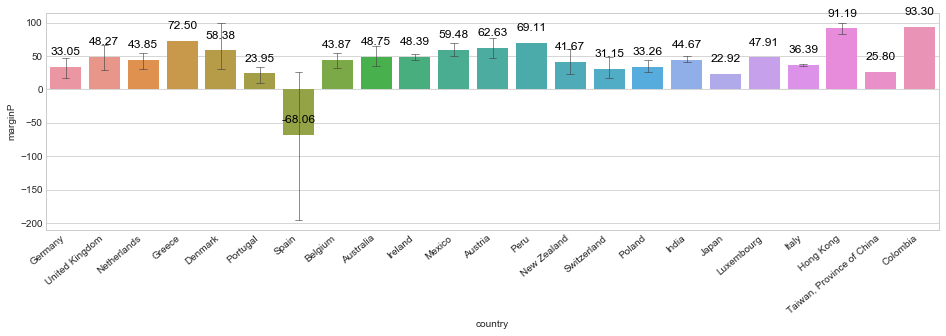

In [3]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="country", y="marginP", data=df_country, capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

Available variables:
    
    Categorical:
    -name
    -managerName
    -client
    -client_id
    -country
    
    Continuous:
    -leads
    -revenue
    -margin
    -cpc
    -cpm
    -cpa
    -clicks
    -views
    
    %:
    -marginP
    -ctr
    -cr

______

# 2. Performance per Marketer

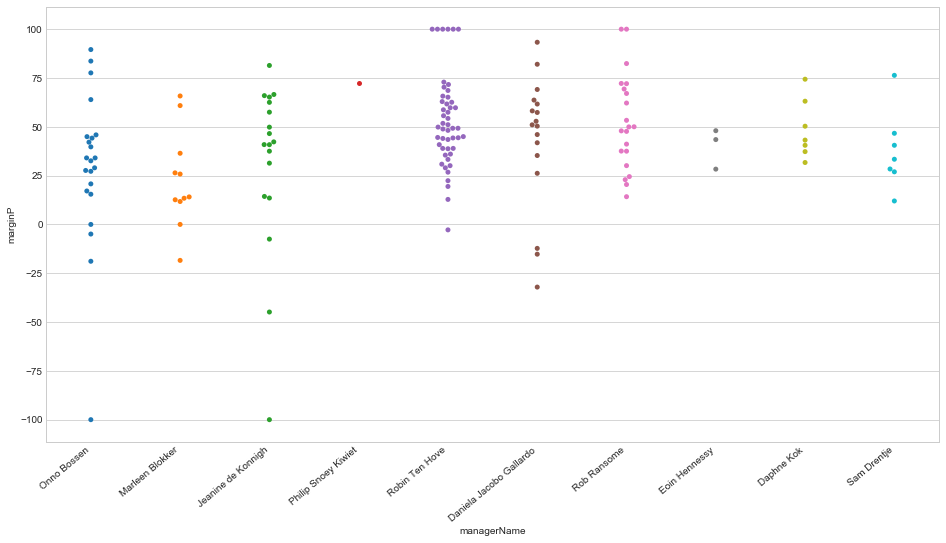

In [4]:
plt.pyplot.figure(figsize=(16,8))
ka=sns.swarmplot(x="managerName", y="marginP", data=df_country.loc[df_country["marginP"]>=-100])
ka.set_xticklabels(ka.get_xticklabels(), rotation=40, ha="right")
ka

________

# 3. Performance per Vertical

Is there info on which clients are in each virtical? 

In [5]:
def yoo(x):
    if x["managerName"]=="Onno Bossen" or x["managerName"]=="Jeanine de Konnigh":
        return("other?")
    if x["managerName"]=="Sam Drentje" or x["managerName"]=="Marleen Blokker" or x["managerName"]=="Daniela Jacobo Gallardo" or x["managerName"]=="Daphne Kok":
        return("NGOs")
    if x["managerName"]=="Philip Snoey Kiwiet" or x["managerName"]=="Robin Ten Hove" or x["managerName"]=="Rob Ransome":
        return("hearing aids")
df_country["vertical"] = df_country.apply(yoo, axis=1)

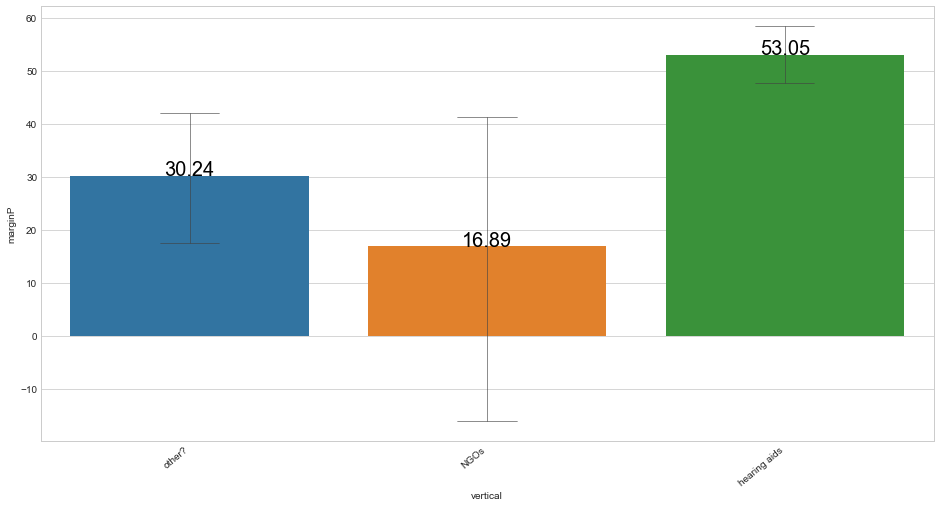

In [6]:
plt.pyplot.figure(figsize=(16,8))
pa=sns.barplot(x="vertical", y="marginP", data=df_country, capsize=.2, errwidth=.6)
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=20, color="black", xytext=(0, 6),
                 textcoords="offset points")

___________

# 4. Performance per Day of the Week

In [7]:
#importing multiple files using glob
#getting bert data
sheetnames=glob.glob("1.country_*.xlsx")
list_of_dfs = [pd.read_excel(sheet) for sheet in sheetnames]
for dataframe, sheet in zip(list_of_dfs, sheetnames):
    dataframe["day_num"] = sheet
df_daily = pd.concat(list_of_dfs, ignore_index=True) 

### Cleaning

In [8]:
#creating day of the week variable
df_daily["day_num"]=df_daily["day_num"].str.split("_").str[1]
def doo(x):
    if x["day_num"] == "1.xlsx":
        return("monday")
    if x["day_num"] == "2.xlsx":
        return("tuesday")
    if x["day_num"] == "3.xlsx":
        return("wednesday")
    if x["day_num"] == "4.xlsx":
        return("thursday")
    if x["day_num"] == "5.xlsx":
        return("friday")
    if x["day_num"] == "6.xlsx":
        return("saturday")
    else:
        return("sunday")
df_daily["day"] = df_daily.apply(doo, axis=1)

#dropping unused columns
df_daily.drop(columns=["id","status","Rejection rate","maxleads","url"], inplace=True)

#1. FIX CTR
def foo(x):
    if x["ctr"] >= 1:
        return(x["ctr"]/10000)
    else:
        return(x["ctr"])
df_daily["ctr"] = df_daily.apply(foo, axis=1)
df_daily["ctr"] = df_daily["ctr"].round(2)

#2. FIX CPC
def roo(x):
    if x["cpc"] >= 1 and x["cpc"] < 1000000:
        return(x["cpc"]/100000)
    if x["cpc"] >= 1000000:
        return(x["cpc"]/1000000)
    else:
        return(x["cpc"])
df_daily["cpc"] = df_daily.apply(roo, axis=1)
df_daily["cpc"] = df_daily["cpc"].round(2)

#3. FIX CPM
def coo(x):
    if x["cpm"] >= 1:
        return(x["cpm"]/1000000)
    else:
        return(x["cpm"])
df_daily["cpm"] = df_daily.apply(coo, axis=1)
df_daily["cpm"] = df_daily["cpm"].round(2)

#4. FIX CR
df_daily["cr"] = df_daily["cr"]/10000
df_daily["cr"] = df_daily["cr"].round(2)

#5. FIX CPA
def too(x):
    if x["cpa"] >= 1:
        return(x["cpa"]/1000000)
    else:
        return(x["cpa"])
df_daily["cpa"] = df_daily.apply(too, axis=1)
df_daily["cpa"] = df_daily["cpa"].round(2)

#6. FIX MARGIN_P
def woo(x):
    if x["purchase"] == 0 and x["revenue"] >= 1:
        return(100)
    if x["purchase"] == 0 and x["revenue"] == 0:
        return(0)
    if x["purchase"] > 0 and x["revenue"] == 0:
        return(-100)
    else:
        return((x["margin"]/x["revenue"])*100)
df_daily["marginP"] = df_daily.apply(woo, axis=1)
df_daily["marginP"] = df_daily["marginP"].round(2)

#7. COUNTRY NAMES
df_daily["country"]=df_daily["countryIso"].str.split("_").str[1]
def get_country_code(x):
    return pycountry.countries.get(alpha_2=x).name
df_daily["country"] = df_daily["country"].apply(get_country_code)
df_daily.drop(columns=["countryIso"], inplace=True)

df_daily.drop(columns=["day_num"], inplace=True)

order=["monday","tuesday","wednesday","thursday","friday","saturday","sunday"]

### Visualising

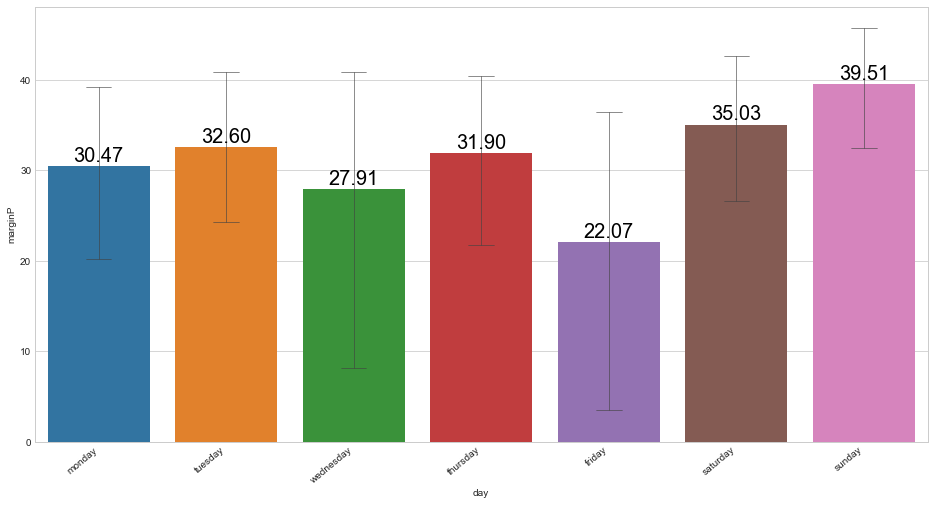

In [9]:
plt.pyplot.figure(figsize=(16,8))
pa=sns.barplot(x="day", y="marginP", data=df_daily, capsize=.2, order=order, errwidth=.6)
pa.set_xticklabels(pa.get_xticklabels(), rotation=40, ha="right")
for p in pa.patches:
             pa.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=20, color="black", xytext=(0, 10),
                 textcoords="offset points")

##### cpa

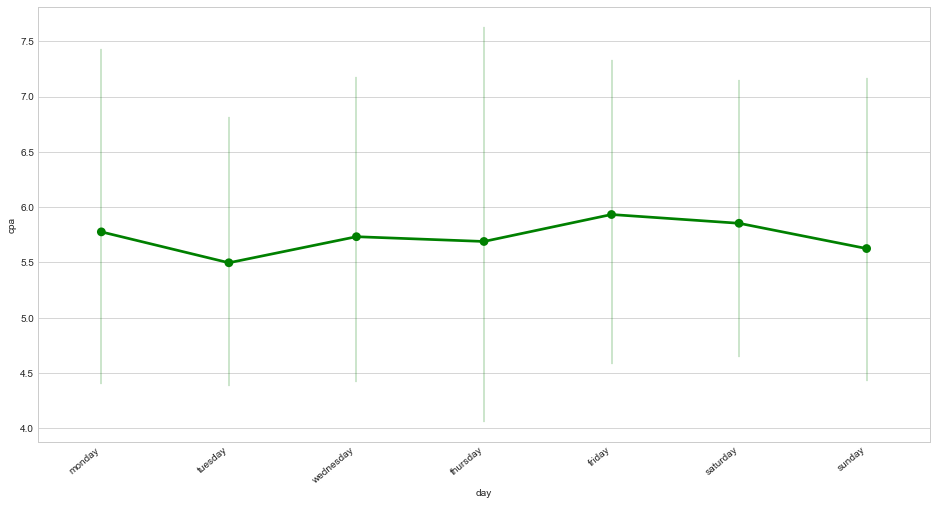

In [10]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cpa", data=df_daily, order=order, color="g", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

##### cpc

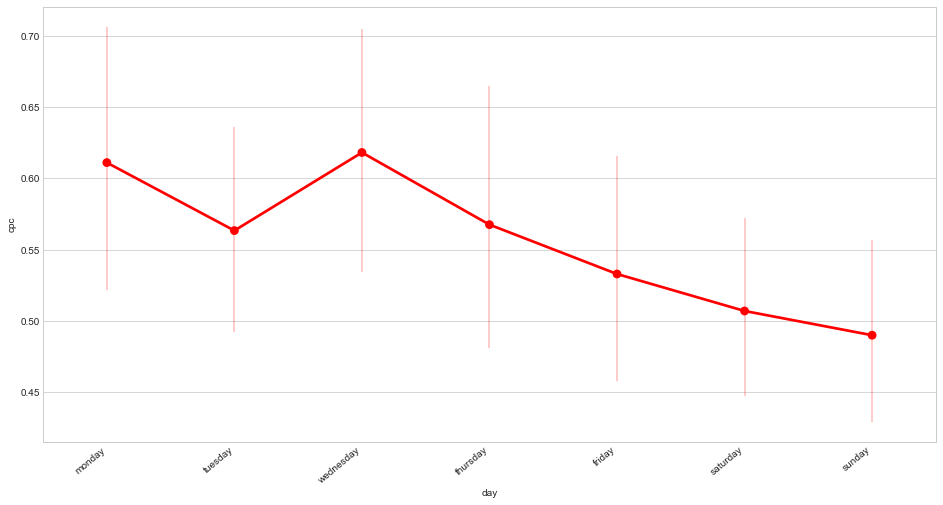

In [11]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cpc", data=df_daily, order=order, color="r", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

##### cpm

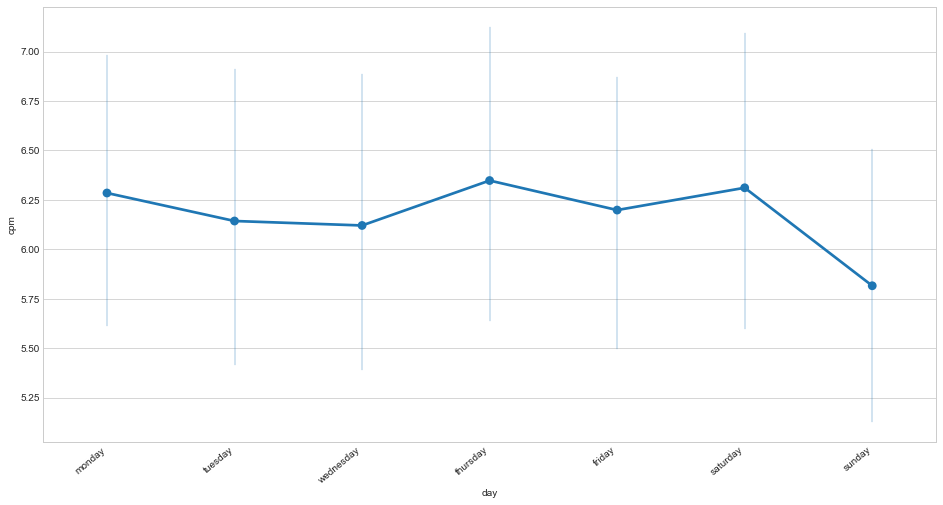

In [12]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cpm", data=df_daily, order=order, dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
for p in ja.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

##### cr

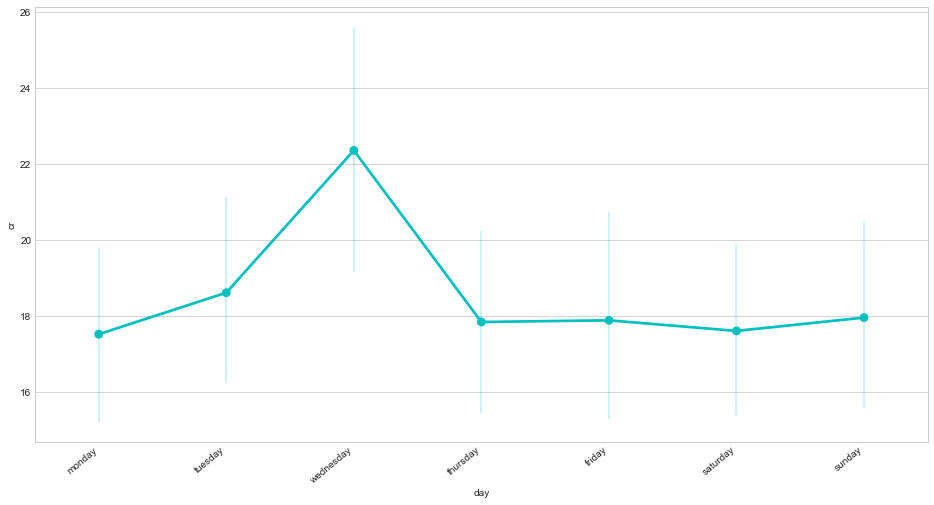

In [13]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="cr", data=df_daily, order=order, color="c", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

##### ctr

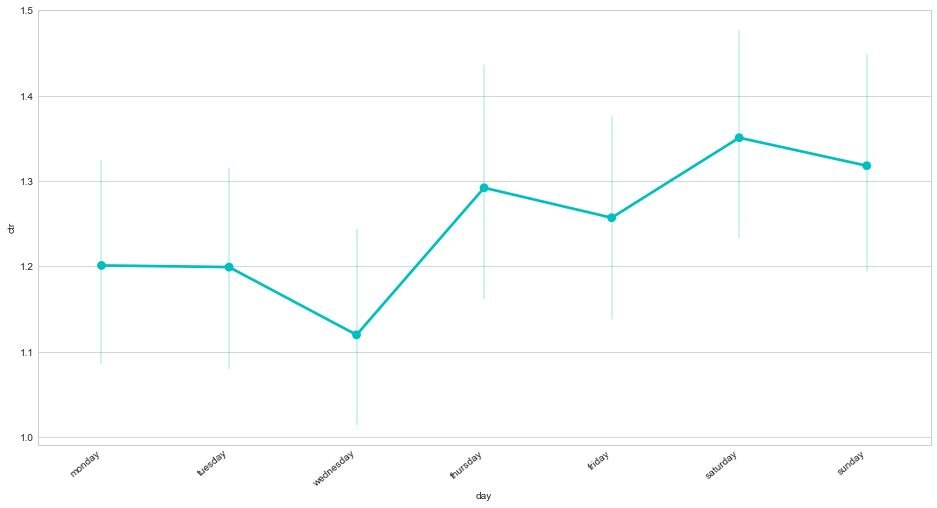

In [14]:
plt.pyplot.figure(figsize=(16,8))
ja=sns.pointplot(x="day", y="ctr", data=df_daily, order=order, color="c", dodge=True, errwidth=.4)
ja.set_xticklabels(ja.get_xticklabels(), rotation=40, ha="right")
ja

_______

# 5. Top performing new ads (that were added during previous week)

##### Cleaning

In [15]:
df_raw=pd.read_excel("1.newads.xlsx")

#subsetting data
df_newads=df_raw.loc[df_raw["insert_time"]>=datetime(2018,5,28)]

#dropping columns
df_newads.drop(columns=["id","status","real_budget","relevanceScore","update_time",
                        "sat_client_id","start_date","end_date","url"], inplace=True)

#1. FIX CTR
def foo(x):
    if x["ctr"] >= 1:
        return(x["ctr"]/10000)
    else:
        return(x["ctr"])
df_newads["ctr"] = df_newads.apply(foo, axis=1)
df_newads["ctr"] = df_newads["ctr"].round(2)

#2. FIX CPC
def roo(x):
    if x["cpc"] >= 1 and x["cpc"] < 1000000:
        return(x["cpc"]/100000)
    if x["cpc"] >= 1000000:
        return(x["cpc"]/1000000)
    else:
        return(x["cpc"])
df_newads["cpc"] = df_newads.apply(roo, axis=1)
df_newads["cpc"] = df_newads["cpc"].round(2)

#3. FIX CPM
def coo(x):
    if x["cpm"] >= 1:
        return(x["cpm"]/1000000)
    else:
        return(x["cpm"])
df_newads["cpm"] = df_newads.apply(coo, axis=1)
df_newads["cpm"] = df_newads["cpm"].round(2)

#4. No fix for CR needed.

#5. FIX CPA
def too(x):
    if x["cpa"] >= 1:
        return(x["cpa"]/1000000)
    else:
        return(x["cpa"])
df_newads["cpa"] = df_newads.apply(too, axis=1)
df_newads["cpa"] = df_newads["cpa"].round(2)

#6. FIX MARGIN_P
def woo(x):
    if x["purchase"] == 0 and x["revenue"] >= 1:
        return(100)
    if x["purchase"] == 0 and x["revenue"] == 0:
        return(0)
    if x["purchase"] > 0 and x["revenue"] == 0:
        return(-100)
    else:
        return((x["margin"]/x["revenue"])*100)
df_newads["marginP"] = df_newads.apply(woo, axis=1)
df_newads["marginP"] = df_newads["marginP"].round(2)



The table below shows new ads that had a margin (percentage) above 50%. They are displayed in descending order from highest margin to lowest. Do these sybolise the most successful ads? We can play around with what matters. 



In [16]:
df_newads.loc[df_newads['marginP']>=50].nlargest(10,'margin')

,tag,campaignName,name,budget,leads,revenue,purchase,margin,marginP,ctr,cpc,cpm,cr,cpa,insert_time,frequency,views,clicks
2088,SB000000001148018,HelloFresh BENL - Kookenqu√™te Vakantiepark,T 10 I Istock May1 J M/F 23+ ALL,100.0,247,518.7,252.65,266.05,51.29,0.0,0.27,3.39,26.1,1.02,2018-05-29 15:11:51,103818333,74540,948
2248,SB000000001149569,Akoustica Medica,T1 I M M/V 50+ D/M - LAL 10%,40.0,20,320.0,83.92,236.08,73.78,0.0,0.34,3.78,8.1,4.20,2018-05-31 11:33:24,103032500,22181,248
2002,SB000000001147544,Akoustica Medica,T1 I K M/V 50+ D/M ALL,20.0,20,320.0,88.32,231.68,72.40,0.7,0.19,1.43,4.3,4.42,2018-05-28 17:06:01,141040000,61587,461
2221,SB000000001148795,Vitakustik IIC,T Mei DESIGN May C M/F 50+ ALL,60.0,14,399.0,167.61,231.39,57.99,0.6,1.15,6.93,9.6,11.97,2018-05-30 13:19:30,120420000,24193,146
2063,SB000000001147874,AudioNova BEFR - White label IIC,T 2 I SB Mar1 D M/F 50+ ALL,50.0,30,360.0,141.84,218.16,60.60,0.9,0.89,7.89,18.8,4.73,2018-05-29 12:48:26,109721667,17967,160
2001,SB000000001147538,Akoustica Medica,T1 I M M/V 50+ D/M - LAL 1%,20.0,19,304.0,88.85,215.15,70.77,0.0,0.38,4.12,8.1,4.68,2018-05-28 16:51:50,106366667,21544,236
2009,SB000000001147580,Connect Hearing - Consumer guide LP,T 2 V CL May1 A M/F 45+ ALL,80.0,15,330.0,132.94,197.06,59.72,0.9,1.58,13.61,17.9,8.86,2018-05-29 11:01:22,128643333,9766,84
2229,SB000000001149287,WWF Germany - Against Coal,T4 I WW241407 M/V 21+ ALL 5% LAL CV,30.0,238,333.2,138.16,195.04,58.54,0.0,0.20,2.50,34.7,0.58,2018-05-30 14:57:29,102494000,55328,686
2062,SB000000001147868,AudioNova BEFR - White label IIC,T 2 I SB Mar1 H M/F 50+ ALL,50.0,28,336.0,141.79,194.21,57.80,0.9,0.78,7.19,15.5,5.06,2018-05-29 12:48:07,107146667,19719,181
2227,SB000000001148993,Bonavox,T2 I D MV50+ M/D/A/RC,40.0,11,287.1,96.17,190.93,66.50,0.8,0.93,7.92,10.7,8.74,2018-05-30 13:51:12,114470000,12143,103



e.g. this shows the top 10 margin (percentage) ads that had margins of over €150, ordered from highest conversion rate to lowest conversion rate.


In [17]:
df_newads.loc[df_newads['margin']>=150].nlargest(10,'marginP').sort_values(by='cr', ascending=False)

,tag,campaignName,name,budget,leads,revenue,purchase,margin,marginP,ctr,cpc,cpm,cr,cpa,insert_time,frequency,views,clicks
1936,SB000000001147256,Save the Children CO - lead ads,T2 I AB M/V 25+ ALL CITIES,7.0,67,160.80,9.33,151.47,94.20,0.0,0.07,0.84,47.5,0.14,2018-05-28 14:48:49,101148000,11064,141
2229,SB000000001149287,WWF Germany - Against Coal,T4 I WW241407 M/V 21+ ALL 5% LAL CV,30.0,238,333.20,138.16,195.04,58.54,0.0,0.20,2.50,34.7,0.58,2018-05-30 14:57:29,102494000,55328,686
1929,SB000000001147052,Save the Children IN - English speaking cities...,T3 IMG I M/V 30+ ALL ‚Äì CONTEXT 1,20.0,207,294.99,110.40,184.59,62.58,0.9,0.11,0.97,19.8,0.53,2018-05-28 13:40:02,101388571,113858,1043
2063,SB000000001147874,AudioNova BEFR - White label IIC,T 2 I SB Mar1 D M/F 50+ ALL,50.0,30,360.00,141.84,218.16,60.60,0.9,0.89,7.89,18.8,4.73,2018-05-29 12:48:26,109721667,17967,160
2009,SB000000001147580,Connect Hearing - Consumer guide LP,T 2 V CL May1 A M/F 45+ ALL,80.0,15,330.00,132.94,197.06,59.72,0.9,1.58,13.61,17.9,8.86,2018-05-29 11:01:22,128643333,9766,84
2227,SB000000001148993,Bonavox,T2 I D MV50+ M/D/A/RC,40.0,11,287.10,96.17,190.93,66.50,0.8,0.93,7.92,10.7,8.74,2018-05-30 13:51:12,114470000,12143,103
2221,SB000000001148795,Vitakustik IIC,T Mei DESIGN May C M/F 50+ ALL,60.0,14,399.00,167.61,231.39,57.99,0.6,1.15,6.93,9.6,11.97,2018-05-30 13:19:30,120420000,24193,146
2248,SB000000001149569,Akoustica Medica,T1 I M M/V 50+ D/M - LAL 10%,40.0,20,320.00,83.92,236.08,73.78,0.0,0.34,3.78,8.1,4.20,2018-05-31 11:33:24,103032500,22181,248
2001,SB000000001147538,Akoustica Medica,T1 I M M/V 50+ D/M - LAL 1%,20.0,19,304.00,88.85,215.15,70.77,0.0,0.38,4.12,8.1,4.68,2018-05-28 16:51:50,106366667,21544,236
2002,SB000000001147544,Akoustica Medica,T1 I K M/V 50+ D/M ALL,20.0,20,320.00,88.32,231.68,72.40,0.7,0.19,1.43,4.3,4.42,2018-05-28 17:06:01,141040000,61587,461


______________

# 6. Campaigns that are dropping in margin from 45% + to below 45%+

In [18]:
#importing new dataset
df_comp_raw=pd.read_excel("1.newads_comp.xlsx")


####FOR WEEK BEFORE DF####


#dropping columns
df_comp_raw.drop(columns=["id","status","real_budget","relevanceScore","update_time",
                        "sat_client_id","start_date","end_date","url"], inplace=True)

#1. FIX CTR
df_comp_raw["ctr"] = df_comp_raw.apply(foo, axis=1)
df_comp_raw["ctr"] = df_comp_raw["ctr"].round(2)

#2. FIX CPC
df_comp_raw["cpc"] = df_comp_raw.apply(roo, axis=1)
df_comp_raw["cpc"] = df_comp_raw["cpc"].round(2)

#3. FIX CPM
df_comp_raw["cpm"] = df_comp_raw.apply(coo, axis=1)
df_comp_raw["cpm"] = df_comp_raw["cpm"].round(2)

#4. No fix for CR needed.

#5. FIX CPA
df_comp_raw["cpa"] = df_comp_raw.apply(too, axis=1)
df_comp_raw["cpa"] = df_comp_raw["cpa"].round(2)

#6. FIX MARGIN_P
df_comp_raw["marginP"] = df_comp_raw.apply(woo, axis=1)
df_comp_raw["marginP"] = df_comp_raw["marginP"].round(2)



####FOR FULL RAW WEEK#####


#dropping columns
df_raw.drop(columns=["id","status","real_budget","relevanceScore","update_time",
                        "sat_client_id","start_date","end_date","url"], inplace=True)

#1. FIX CTR
df_raw["ctr"] = df_raw.apply(foo, axis=1)
df_raw["ctr"] = df_raw["ctr"].round(2)

#2. FIX CPC
df_raw["cpc"] = df_raw.apply(roo, axis=1)
df_raw["cpc"] = df_raw["cpc"].round(2)

#3. FIX CPM
df_raw["cpm"] = df_raw.apply(coo, axis=1)
df_raw["cpm"] = df_raw["cpm"].round(2)

#4. No fix for CR needed.

#5. FIX CPA
df_raw["cpa"] = df_raw.apply(too, axis=1)
df_raw["cpa"] = df_raw["cpa"].round(2)

#6. FIX MARGIN_P
df_raw["marginP"] = df_raw.apply(woo, axis=1)
df_raw["marginP"] = df_raw["marginP"].round(2)


#####SLIMMING COMB DATA DOWN TO ONLY INCLUDE MARGINS ABOVE 45%###########
df_comp=df_comp_raw.loc[df_comp_raw["marginP"]>=45]

####COMBING DATA SETS########
df_campaign2=df_comp.merge(df_raw, how ="inner", on = ["tag"])

The list below contains every ad that went from being 45% margin or higher, but dropped below 45% margin the following week. 

Unfortunately, however, there are 263 ads in which this occured. 

In [19]:
df_campaign=df_campaign2.loc[df_campaign2["marginP_y"]<45]
df_campaign

,tag,campaignName_x,name_x,budget_x,leads_x,revenue_x,purchase_x,margin_x,marginP_x,ctr_x,cpc_x,cpm_x,cr_x,cpa_x,insert_time_x,frequency_x,views_x,clicks_x,campaignName_y,name_y,budget_y,leads_y,revenue_y,purchase_y,margin_y,marginP_y,ctr_y,cpc_y,cpm_y,cr_y,cpa_y,insert_time_y,frequency_y,views_y,clicks_y
9,SB000000001081700,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Charleroi M/V 25+ ALL STR1,5.0,34,81.60,36.10,45.50,55.76,0.0,0.31,4.27,28.8,1.06,2017-09-19 09:58:54,105768571,8447,118,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Charleroi M/V 25+ ALL STR1,5.0,25,60.00,33.49,26.51,44.18,0.8,0.45,3.77,33.3,1.34,2017-09-19 09:58:54,109497143,8888,75
11,SB000000001081721,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Verviers M/V 25+ ALL STR1,2.0,14,33.60,14.43,19.17,57.05,0.0,0.42,4.09,41.2,1.03,2017-09-19 09:59:33,106107143,3530,34,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Verviers M/V 25+ ALL STR1,2.0,9,21.60,13.33,8.27,38.29,0.8,0.51,4.07,34.6,1.48,2017-09-19 09:59:33,108430000,3272,26
13,SB000000001081730,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Binche M/V 25+ ALL STR1,2.0,12,28.80,14.23,14.57,50.59,0.0,0.38,4.13,32.4,1.19,2017-09-19 09:59:55,107840000,3449,37,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Binche M/V 25+ ALL STR1,2.0,9,21.60,13.24,8.36,38.70,0.0,0.35,3.85,23.7,1.47,2017-09-19 09:59:55,109257143,3438,38
16,SB000000001086889,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Arlon M/V 25+ ALL STR1,5.0,31,74.40,36.13,38.27,51.44,0.0,0.36,4.42,30.7,1.17,2017-10-11 14:09:03,107398571,8180,101,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Arlon M/V 25+ ALL STR1,5.0,12,28.80,33.17,-4.37,-15.17,0.0,0.38,4.34,13.8,2.76,2017-10-11 14:09:03,108325714,7641,87
17,SB000000001086946,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Mouscron M/V 25+ ALL STR1,2.0,15,36.00,14.59,21.41,59.47,0.0,0.42,4.46,42.9,0.97,2017-10-11 14:25:40,106550000,3271,35,HelloFresh BEFR - Spaanse Keukenquiz,T 1.2 I G Mouscron M/V 25+ ALL STR1,2.0,7,16.80,13.30,3.50,20.83,0.0,0.35,4.22,18.4,1.90,2017-10-11 14:25:40,110711429,3150,38
20,SB000000001087162,Vergelijkhulp BENL - (BesparenKan) - QZ,T2.1 Slideshow Oct1 Prov-West-Vlaanderen 25+ ALL,10.0,16,79.20,28.22,50.98,64.37,0.0,0.29,6.91,16.7,1.76,2017-10-12 11:28:52,100815714,4085,96,Vergelijkhulp BENL - (BesparenKan) - QZ,T2.1 Slideshow Oct1 Prov-West-Vlaanderen 25+ ALL,10.0,19,94.05,55.57,38.48,40.91,0.0,0.26,6.18,8.8,2.92,2017-10-12 11:28:52,101075714,8997,216
25,SB000000001091068,AudicaoActiva PT - ReSound - lead ads,LEAD AD T1 I MAY17 AV 50+ M/D - NWCH,60.0,67,1115.55,529.24,586.31,52.56,0.7,0.70,4.76,8.8,7.90,2017-10-27 15:27:27,105612857,111162,758,AudicaoActiva PT - ReSound - lead ads,LEAD AD T1 I MAY17 AV 50+ M/D - NWCH,60.0,15,249.75,199.28,50.47,20.21,0.7,0.64,4.45,4.8,13.29,2017-10-27 15:27:27,103863333,44755,313
31,SB000000001098736,HelloFresh BEFR - Italiaanse Keukenquiz - alge...,T 2.6 I Istock Sept1 I M/V 23+ ALL COPY,100.0,114,273.60,107.42,166.18,60.74,0.8,0.47,3.59,49.8,0.94,2017-11-27 11:26:40,107500000,29957,229,HelloFresh BEFR - Italiaanse Keukenquiz - alge...,T 2.6 I Istock Sept1 I M/V 23+ ALL COPY,100.0,220,528.00,295.15,232.85,44.10,0.8,0.59,4.53,43.8,1.34,2017-11-27 11:26:40,107980000,65213,502
32,SB000000001099216,Bloom Hearing regular,T1 I color Widex hand M/F 50+ ALL RM,20.0,15,404.55,90.42,314.13,77.65,0.0,0.96,13.19,16.0,6.03,2017-11-29 09:58:27,119086000,6857,94,Bloom Hearing regular,T1 I color Widex hand M/F 50+ ALL RM,20.0,1,26.97,37.83,-10.86,-40.27,0.0,0.59,12.52,1.6,37.83,2017-11-29 09:58:27,115023333,3021,64
37,SB000000001103729,Save the children IN - Rest of India - lead ads,T 3 I B M/V 30+ ALL ‚Äì CONTEXT 1,20.0,279,397.60,205.17,192.43,48.40,0.8,0.14,1.14,19.6,0.74,2017-12-29 11:08:18,101942857,179759,1422,Save the children IN - Rest of India - lead ads,T 3 I B M/V 30+ ALL ‚Äì CONTEXT 1,20.0,179,255.10,166.55,88.55,34.71,0.6,0.20,1.22,21.3,0.93,2017-12-29 11:08:18,101135000,136043,839


In [20]:
#making difference variable
df_campaign["diff"]=df_campaign["marginP_x"]-(df_campaign["marginP_y"])

These are the 20 ads that had the biggest differences (in margin percentage) between the two weeks. 

In [21]:
df_campaign.nlargest(20,'diff')

,tag,campaignName_x,name_x,budget_x,leads_x,revenue_x,purchase_x,margin_x,marginP_x,ctr_x,cpc_x,cpm_x,cr_x,cpa_x,insert_time_x,frequency_x,views_x,clicks_x,campaignName_y,name_y,budget_y,leads_y,revenue_y,purchase_y,margin_y,marginP_y,ctr_y,cpc_y,cpm_y,cr_y,cpa_y,insert_time_y,frequency_y,views_y,clicks_y,diff
468,SB000000001143218,AudioNova BEFR - White label IIC - Cities,T 7 I SB Mar1 G M/F 50+ ALL City-47+ Chimay,3.0,1,12.00,0.38,11.62,96.83,0.0,0.38,27.14,100.0,0.38,2018-05-18 15:50:48,116670000,14,1,AudioNova BEFR - White label IIC - Cities,T 7 I SB Mar1 G M/F 50+ ALL City-47+ Chimay,3.0,0,0.0,0.42,-0.42,-100.0,0.0,0.00,15.56,0.0,0.0,2018-05-18 15:50:48,108000000,27,0,196.83
508,SB000000001145102,Bloom Hearing UK - beyond RSP - City ads,Ashford¬†- City4 V colour BEYOND VC M/V 50+ ALL,3.0,2,52.20,4.24,47.96,91.88,0.0,0.33,16.43,15.4,2.12,2018-05-24 12:58:40,103520000,258,13,Bloom Hearing UK - beyond RSP - City ads,Ashford¬†- City4 V colour BEYOND VC M/V 50+ ALL,3.0,0,0.0,2.97,-2.97,-100.0,0.0,0.37,14.35,0.0,0.0,2018-05-24 12:58:40,101210000,207,8,191.88
523,SB000000001145285,Bloom Hearing UK - beyond RSP - City ads,Telford ¬†- City4 V colour BEYOND VC M/V 50+ ALL,3.0,2,52.20,4.29,47.91,91.78,0.0,0.33,14.54,15.4,2.14,2018-05-24 13:16:23,103055000,295,13,Bloom Hearing UK - beyond RSP - City ads,Telford ¬†- City4 V colour BEYOND VC M/V 50+ ALL,3.0,0,0.0,2.74,-2.74,-100.0,0.0,0.27,10.87,0.0,0.0,2018-05-24 13:16:23,100470000,252,10,191.78
496,SB000000001144592,Vitakustik IIC - Cities,T1 V SB MAY CV 50+ ALL - Niedersachsen -City2,3.0,4,114.00,13.06,100.94,88.54,0.0,0.93,13.23,28.6,3.26,2018-05-23 14:57:58,102760000,987,14,Vitakustik IIC - Cities,T1 V SB MAY CV 50+ ALL - Niedersachsen -City2,3.0,0,0.0,15.63,-15.63,-100.0,0.0,1.30,14.58,0.0,0.0,2018-05-23 14:57:58,103515000,1072,12,188.54
535,SB000000001146188,GEERS DE - IIC QZ V3 - New - Cities,T 6 V SB Mar2 B M/F 50+ ALL City-02 -[Kaisersl...,2.0,2,36.00,4.70,31.30,86.94,0.0,0.94,11.38,40.0,2.35,2018-05-25 13:24:36,105343333,413,5,GEERS DE - IIC QZ V3 - New - Cities,T 6 V SB Mar2 B M/F 50+ ALL City-02 -[Kaisersl...,2.0,0,0.0,13.74,-13.74,-100.0,0.7,1.72,11.87,0.0,0.0,2018-05-25 13:24:36,108694286,1158,8,186.94
544,SB000000001146293,GEERS DE - IIC QZ V3 - New - Cities,T 6 V SB Mar2 B M/F 50+ ALL City-02 -[Leipzig],2.0,2,36.00,4.73,31.27,86.86,0.0,0.79,11.05,33.3,2.37,2018-05-25 13:47:38,108943333,428,6,GEERS DE - IIC QZ V3 - New - Cities,T 6 V SB Mar2 B M/F 50+ ALL City-02 -[Leipzig],2.0,0,0.0,13.84,-13.84,-100.0,0.9,1.38,12.32,0.0,0.0,2018-05-25 13:47:38,110244286,1123,10,186.86
140,SB000000001122269,Bloom Hearing regular - City ads,Newcastle-upon-Tyne - CITY3 M/V 50+ ALL,5.0,6,161.82,22.57,139.25,86.05,0.0,1.03,12.39,27.3,3.76,2018-03-20 10:15:44,101452000,1821,22,Bloom Hearing regular - City ads,Newcastle-upon-Tyne - CITY3 M/V 50+ ALL,5.0,0,0.0,4.52,-4.52,-100.0,0.3,4.52,11.41,0.0,0.0,2018-03-20 10:15:44,100145000,396,1,186.05
511,SB000000001145117,Bloom Hearing UK - beyond RSP - City ads,Boston¬†- City4 V colour BEYOND VC M/V 50+ ALL,3.0,1,26.10,3.84,22.26,85.29,0.0,0.38,13.67,10.0,3.84,2018-05-24 13:00:12,102750000,281,10,Bloom Hearing UK - beyond RSP - City ads,Boston¬†- City4 V colour BEYOND VC M/V 50+ ALL,3.0,0,0.0,2.66,-2.66,-100.0,0.0,0.38,11.88,0.0,0.0,2018-05-24 13:00:12,102430000,224,7,185.29
516,SB000000001145177,Bloom Hearing UK - beyond RSP - City ads,Huntingdon ¬†- City4 V colour BEYOND VC M/V 50...,3.0,1,26.10,3.94,22.16,84.90,0.0,0.33,15.45,8.3,3.94,2018-05-24 13:07:01,105040000,255,12,Bloom Hearing UK - beyond RSP - City ads,Huntingdon ¬†- City4 V colour BEYOND VC M/V 50...,3.0,0,0.0,2.74,-2.74,-100.0,0.0,0.55,15.57,0.0,0.0,2018-05-24 13:07:01,102595000,176,5,184.90
514,SB000000001145159,Bloom Hearing UK - beyond RSP - City ads,Gateshead ¬†- City4 V colour BEYOND VC M/V 50+...,3.0,1,26.10,4.05,22.05,84.48,0.0,1.35,14.52,33.3,4.05,2018-05-24 13:04:45,103860000,279,3,Bloom Hearing UK - beyond RSP - City ads,Gateshead ¬†- City4 V colour BEYOND VC M/V 50+...,3.0,0

______

### Other testing

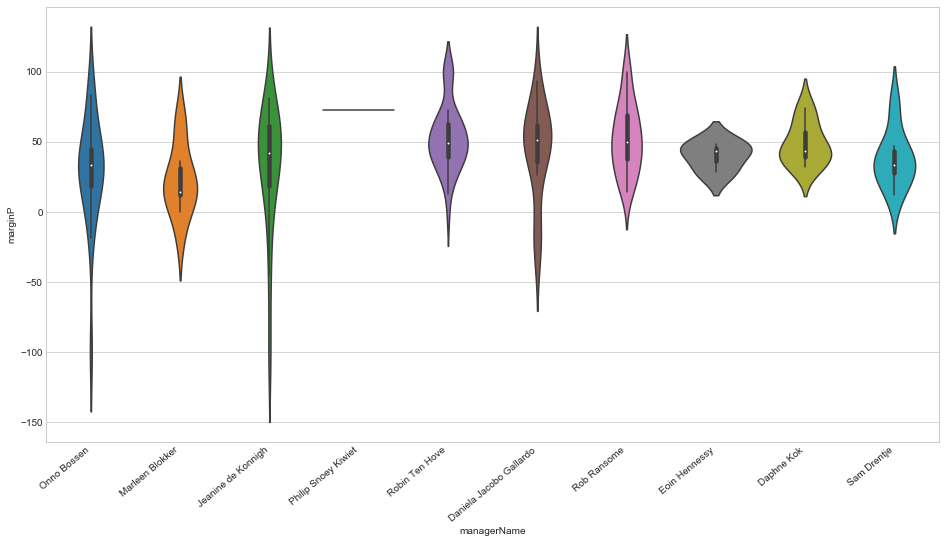

In [22]:
plt.pyplot.figure(figsize=(16,8))
waa=sns.violinplot(x="managerName", y="marginP", data=df_country.loc[df_country["marginP"]>-200])
waa.set_xticklabels(waa.get_xticklabels(), rotation=40, ha="right")
waa

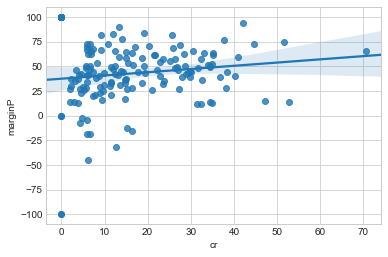

In [23]:
sns.regplot(x="cr", y="marginP", data=df_country.loc[df_country["marginP"]>=-100])

In [24]:
df_country.describe()

,client_id,leads,revenue,purchase,margin,marginP,ctr,cpc,cpm,cr,cpa,clicks,views
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,1.580000e+02
mean,1482.949367,296.398734,1168.922215,646.137468,522.784747,36.958228,1.202722,0.561392,6.312215,16.581392,5.807089,1921.930380,1.793739e+05
std,670.716290,542.566277,1482.758264,872.568585,719.300183,62.461555,0.688265,0.485118,4.510182,13.218336,6.995073,3872.731637,3.509885e+05
min,17.000000,0.000000,0.000000,0.000000,-117.900000,-555.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1199.000000,24.000000,243.425000,128.092500,79.860000,28.337500,0.752500,0.242500,3.045000,6.005000,1.095000,251.250000,1.853075e+04
50%,1589.000000,109.000000,667.280000,338.040000,246.065000,44.240000,1.065000,0.420000,4.705000,13.375000,2.495000,688.500000,6.674000e+04
75%,1955.000000,285.500000,1454.662500,807.925000,701.695000,62.050000,1.525000,0.727500,9.300000,26.315000,9.692500,1767.500000,1.817158e+05
max,2819.000000,4111.000000,10368.000000,6263.340000,4591.180000,100.000000,4.150000,3.270000,19.190000,70.550000,41.280000,36944.000000,3.008375e+06


In [1]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>